<a href="https://colab.research.google.com/github/ANCAMABEBA/Module11/blob/main/VehiclesPricesModeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---

## **Multiple Model Building**

In this section, we experiment with multiple regression models to evaluate their performance and determine which approach provides the best predictive accuracy and generalization. We begin with a **baseline Linear Regression model**, which serves as a reference point for comparing more advanced techniques. The baseline model establishes a minimum expected performance level, enabling us to assess whether additional methods such as **Ridge Regression, Lasso Regression, Random Forest, or Gradient Boosting** provide meaningful improvements. Each model will be trained using the same train/test split to ensure comparability, and performance will be measured using standard evaluation metrics such as **RMSE** (Root Mean Squared Error) and **R²** (coefficient of determination). This systematic comparison helps identify the most effective modeling strategy for predicting car prices and understanding the key drivers of variability in the data.

---


In [2]:
# import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
import shap
from sklearn.model_selection import RandomizedSearchCV

In [3]:
# read X and y from sample_data
X = pd.read_csv('/content/sample_data/X.csv')
y = pd.read_csv('/content/sample_data/y.csv')
print(X.shape)
print(y.shape)

(379065, 55)
(379065, 1)


In [4]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 379065 entries, 0 to 379064
Data columns (total 55 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   year                    379065 non-null  float64
 1   odometer                379065 non-null  float64
 2   manufacturer_category   379065 non-null  int64  
 3   condition_numeric       379065 non-null  int64  
 4   cylinders_clean         379065 non-null  float64
 5   cylinders_unknown_flag  379065 non-null  int64  
 6   drive_4wd               379065 non-null  int64  
 7   drive_Unknown           379065 non-null  int64  
 8   drive_fwd               379065 non-null  int64  
 9   drive_rwd               379065 non-null  int64  
 10  fuel_Unknown            379065 non-null  int64  
 11  fuel_diesel             379065 non-null  int64  
 12  fuel_electric           379065 non-null  int64  
 13  fuel_gas                379065 non-null  int64  
 14  fuel_hybrid         

In [5]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [6]:
# Apply linear regression model as our base model
# Standarize features before modelling
pipe = Pipeline([
    ('scaler', StandardScaler()),   # scale only X
    ('model', LinearRegression())
])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
# calculate MSE, RMSE and R2
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)   # this is the RMSE
r2 = r2_score(y_test, y_pred)

rmse, r2

(np.float64(12035.957141515291), 0.3775689412953628)

---

## **Interpretation of Baseline Model Performance**

The baseline Linear Regression model produced the following evaluation metrics:

- **RMSE (Root Mean Squared Error): 12,035**
- **R² (Coefficient of Determination): 0.377**

### **What these results mean**
The **RMSE value of 12,035** indicates that, on average, the model’s predictions are off by approximately **$12,035** from the actual car price. This error magnitude is meaningful because it reflects the typical size of prediction deviations in real-world units. Given the wide range of used car prices, this level of error may be expected at an early modeling stage, but it highlights substantial room for improvement.

The **R² value of 0.377** indicates that the model explains **37.7% of the variation** in car prices. In other words, roughly **62.3% of the price variability** remains unexplained by the current model. This suggests that price is influenced by additional factors not fully captured by the current feature set or that nonlinear relationships may exist that a simple linear model cannot capture.

### **Conclusion**
This baseline model serves as an essential benchmark. It provides a reference point for evaluating whether more advanced techniques—such as **Ridge, Lasso, Random Forest, or Gradient Boosting**—offer meaningful performance improvements. The next steps will involve testing additional models, feature selection and exploring non-linear methods to increase predictive accuracy and interpretability.

---


---

## **Feature Importance & Model Interpretation**

Now that we have established a baseline Linear Regression model, the next step is to interpret which features have the greatest influence on car price. This is essential to achieve the project’s business objective: understanding what factors make a car more or less expensive and providing actionable recommendations to a used car dealership. By examining the model’s coefficients and relative importance of each variable, we can identify which features most strongly increase price, which decrease it, and how meaningful each factor is in explaining price variability.

We will extract and rank feature coefficients from the regression model, comparing the magnitude and direction of feature impacts. We will also validate stability using regularized models such as **Ridge** and **Lasso**, which help manage multicollinearity and identify the strongest predictors. These insights will support business-driven decisions about inventory strategy, pricing practices, and value-added vehicle characteristics.

---


In [7]:
# Extract coefficients from linear regression inside pipeline
coef = pipe.named_steps['model'].coef_.ravel()

coefficients = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient': coef
})

coefficients['abs_coef'] = coefficients['coefficient'].abs()
coefficients_sorted = coefficients.sort_values(by='abs_coef', ascending=False)

coefficients_sorted.head(20)



,feature,coefficient,abs_coef
5,cylinders_unknown_flag,5071.613214,5071.613214
4,cylinders_clean,4728.595815,4728.595815
0,year,4410.036287,4410.036287
11,fuel_diesel,2093.464068,2093.464068
2,manufacturer_category,1640.450039,1640.450039
1,odometer,-1501.307648,1501.307648
6,drive_4wd,1276.046685,1276.046685
20,transmission_other,1265.048145,1265.048145
8,drive_fwd,-1258.334196,1258.334196
13,fuel_gas,-1224.537324,1224.537324


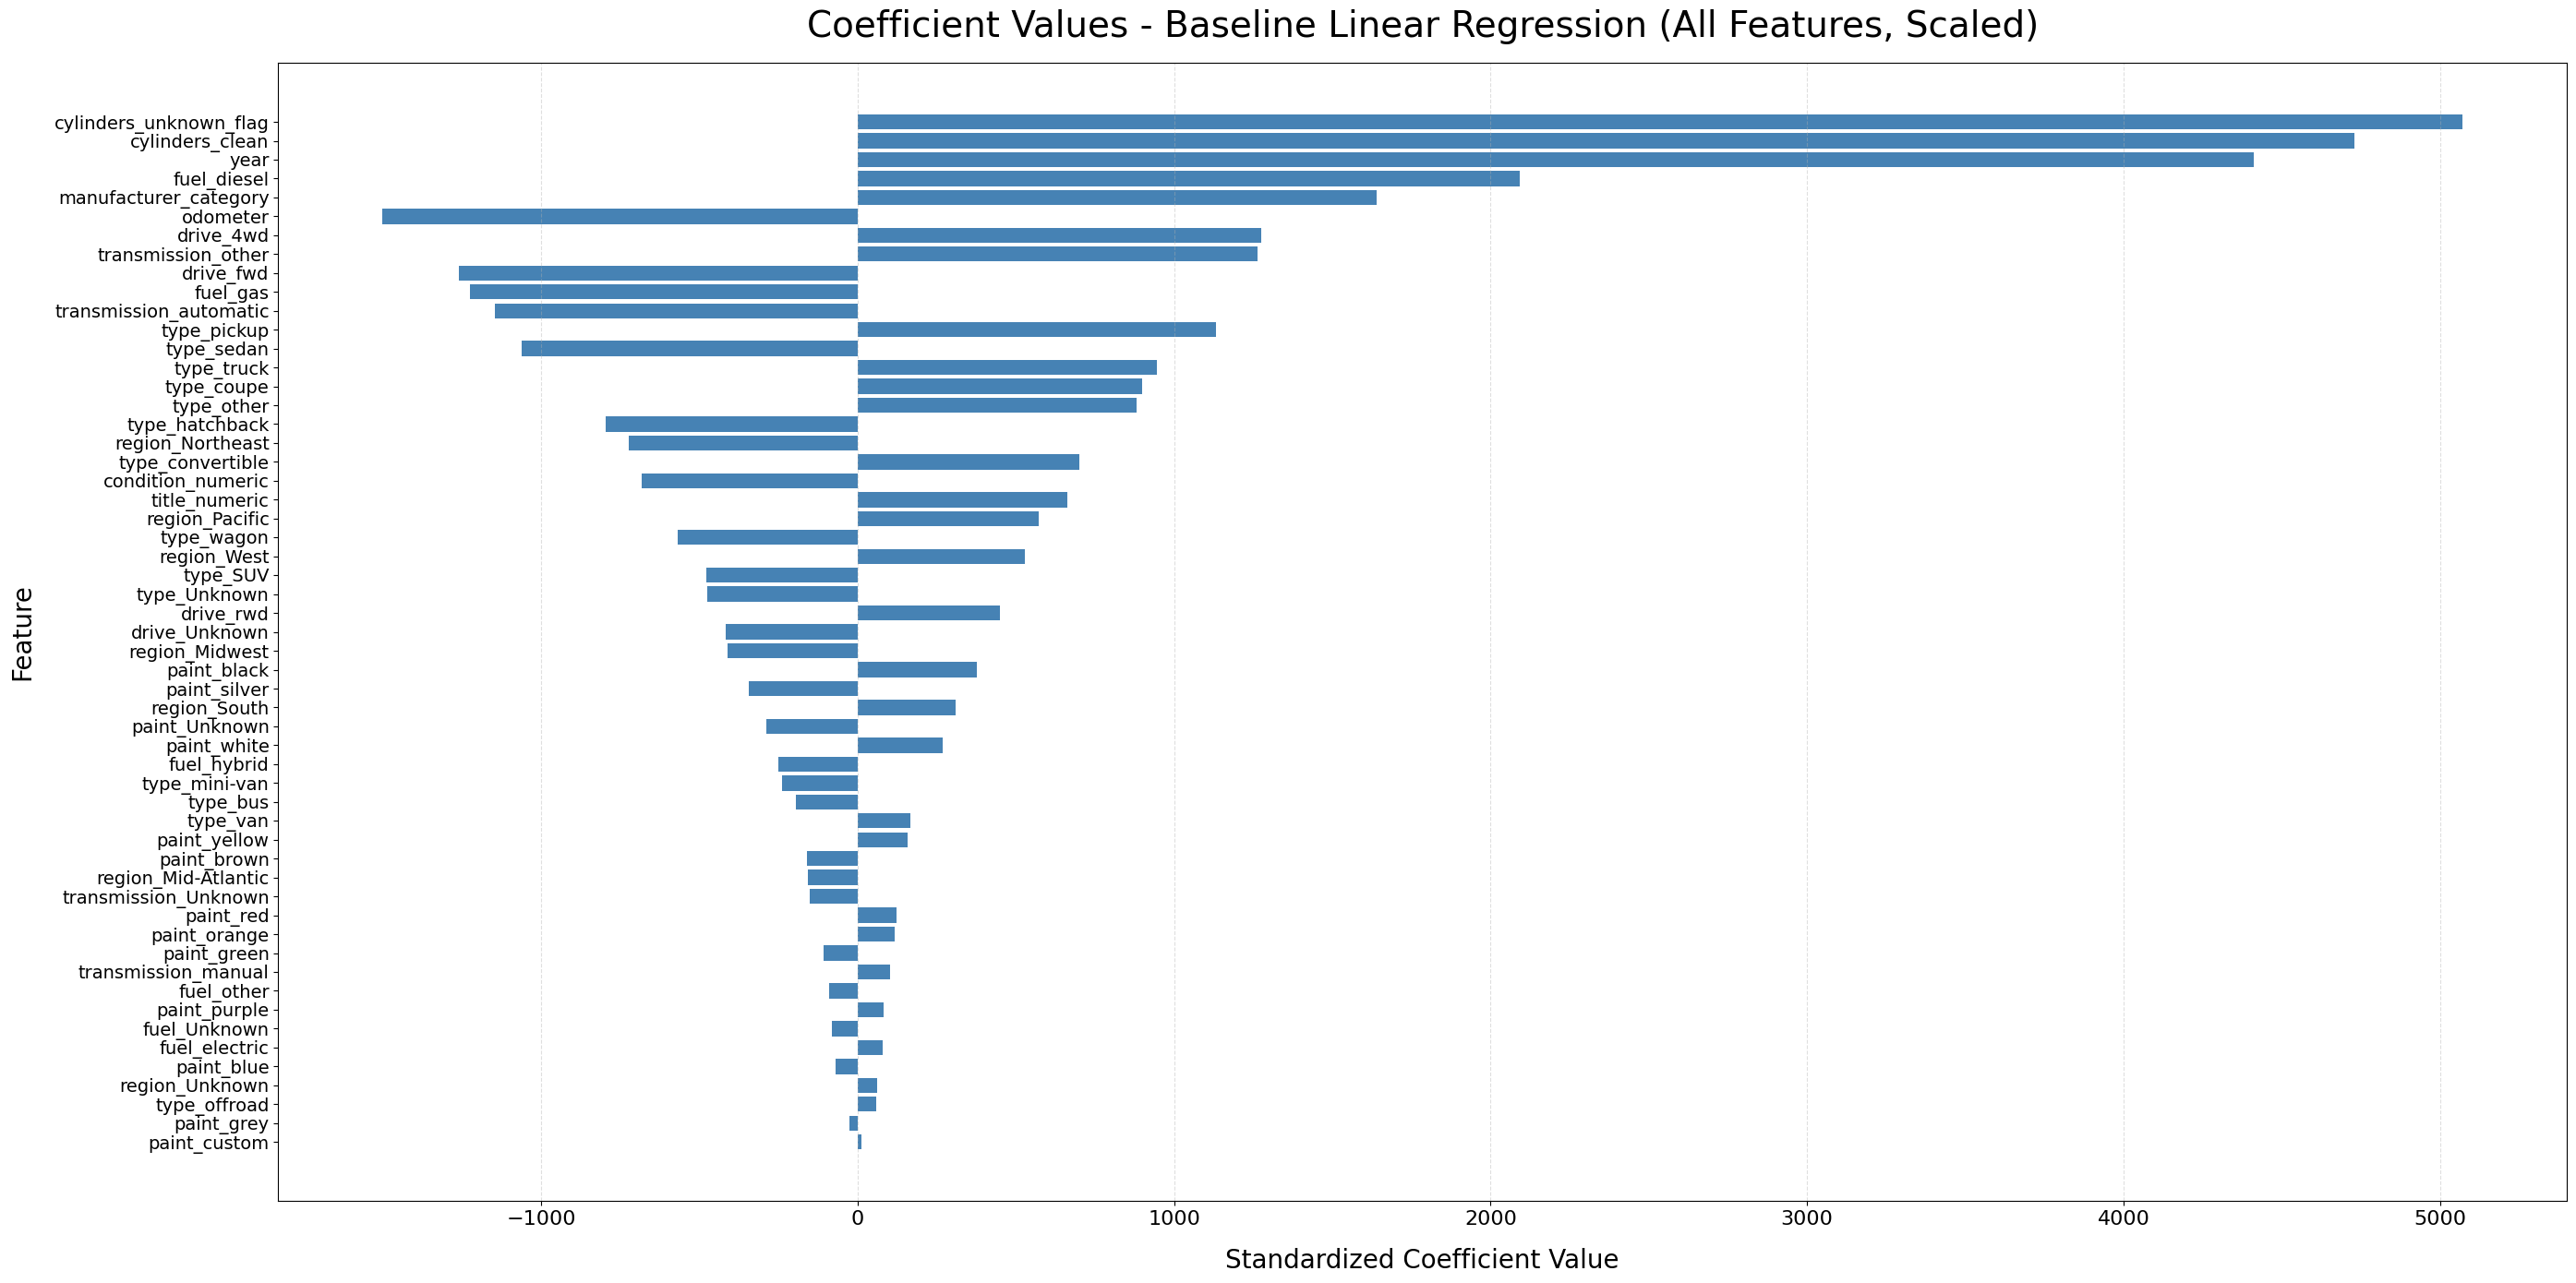

In [8]:
# Plot coefficients for the scaled regression model with all features
# Sort features by magnitude of impact
coef_baseline_sorted = coefficients_sorted.copy()  # already sorted by abs_coef descending

plt.figure(figsize=(28,14))

plt.barh(
    coef_baseline_sorted['feature'],
    coef_baseline_sorted['coefficient'],
    color='steelblue'
)

plt.gca().invert_yaxis()  # Largest effects appear at top

plt.title(
    "Coefficient Values - Baseline Linear Regression (All Features, Scaled)",
    fontsize=28,
    pad=20
)

plt.xlabel("Standardized Coefficient Value", fontsize=20, labelpad=15)
plt.ylabel("Feature", fontsize=20, labelpad=15)

plt.xticks(fontsize=16)
plt.yticks(fontsize=14)

plt.grid(axis='x', linestyle='--', alpha=0.4)

plt.tight_layout()

# ---- SAVE IMAGE ----
plt.savefig("coef_comparison_models.png", dpi=300, bbox_inches='tight')

plt.show()



# Analysis of Coefficient Values – Baseline Linear Regression (All Features, Scaled)

The chart visualizes standardized coefficients from a baseline linear regression model predicting vehicle price using a wide set of engineered and one-hot-encoded features. Since the features were standardized prior to training, coefficient magnitudes are directly comparable, allowing clear interpretation of feature importance and directional effect.

---

## Top Positive Predictors of Vehicle Price
These features have the strongest positive influence on price when controlling for all other variables:

| Feature | Interpretation |
|--------|---------------|
| **cylinders_unknown_flag**, **cylinders_clean** | Engine size / cylinder count is strongly correlated with higher price; unknown values may implicitly represent high-end vehicles |
| **year** | Newer vehicles command a higher price |
| **fuel_diesel** | Diesel engines often correspond to trucks/commercial vehicles with higher price |
| **manufacturer_category** | Captures premium vs mainstream brand effects |
| **drive_4wd**| 4WD transmission commands premium prices |
| **vehicle types such as type_truck / type_pickup / type_SUV / type_coupe /  type_convertible** |Larger utility-oriented vehicles have higher resale values |

➡ **Conclusion:** Performance characteristics, year, manufacturer, drive system, and some body types dominate possitive pricing influence.

---

## Top Negative Predictors of Vehicle Price

| Feature | Interpretation |
|--------|---------------|
| **odometer** | Has a strong effect in reducing price as expected |
| **transmission_automatic** | Automatic transmissions reduce price |
| **region dummy variables (West, Midwest, etc.)** | Geographic price variation — some markets like Northeast have lower average resale values |
| **type categories: sedan, hatchback** | Lower demand relative to trucks & SUVs and other types |
| **paint colors:** | Do not seem to have a strong influence. Non-popular colors may reduce market value |


➡ **Conclusion:** Odometer, automatic transmision, and popular types (sedan, hatchback) strongly reduce pricing.

---

## Key Insights

### 1. **Cylinders, year and Manufacturer Category dominate**
- These coefficients are significantly larger than others
- Potential multicollinearity → We will apply **regularization techniques**

### 2. **Odometer, manual transmission and popular types drive strong negative impact**
- Usually mileage reduces price and some popular body types have lower reselling price comparatevely

### 3. **Regional pricing variability**
- Location-based pricing may be factor in some regions (Northeast).

---

## Summary

The coefficient plot shows that **engine power, manufacturer category, drive system, and vehicle type** are the largest drivers of price, while **odometer, standard transmission and body types** significantly reduce price. Some  negative effects observed for some regions and the impact of colors do not seem that significant.
---


---

## **Sequential Feature Selection (SFS)**

After establishing a baseline linear regression model and examining feature importance, the next step is to identify the subset of features that best explains the variability in car prices. Although our dataset includes a large number of predictors—especially after one-hot encoding categorical variables— not all features contribute meaningfully to the model. Some may introduce noise, multicollinearity, or unnecessary complexity.

To address this, we apply **Sequential Feature Selection (SFS)**, a wrapper method that iteratively evaluates feature subsets based on model performance. SFS helps determine the most valuable predictors for price, improving both interpretability and model efficiency. By starting with no features and adding the strongest predictors one by one (forward selection), we aim to identify a smaller set of variables that maintain or improve model performance compared to the full feature set.

This step aligns with the CRISP-DM objective of building models that provide actionable business insights: understanding which vehicle characteristics most strongly drive price differences and enabling more informed pricing and inventory decisions.

---


In [9]:
# Create pipeline that scales X before fitting linear regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

# Sequential Forward Selection for 15 features
sfs = SequentialFeatureSelector(
    estimator=pipeline,            # IMPORTANT: use pipeline here
    n_features_to_select=15,
    direction='forward',
    scoring='r2',
    cv=5,
    n_jobs=-1
)

# Fit SFS on training data (X no scaling needed here; the pipeline handles it internally)
sfs.fit(X_train, y_train)

# Extract selected feature names
selected_features = X_train.columns[sfs.get_support()]
print("Selected Features:")
print(selected_features)


Selected Features:
Index(['year', 'odometer', 'manufacturer_category', 'condition_numeric',
       'drive_Unknown', 'drive_fwd', 'fuel_diesel', 'fuel_gas',
       'transmission_other', 'type_convertible', 'type_coupe', 'type_other',
       'type_pickup', 'type_sedan', 'type_truck'],
      dtype='object')


---

## **Sequential Feature Selection (SFS) Results – 15 Features**

To improve model interpretability and identify the most impactful predictors of used-car pricing, we performed Sequential Forward Feature Selection using a target of 15 features. This method evaluates combinations of predictors and selects the subset that maximizes model performance based on cross-validated R².

### **Selected Features**
`year`, `odometer`, `manufacturer_category`, `condition_numeric`, `drive_Unknown`, `drive_fwd`, `fuel_diesel`, `fuel_gas`,
`transmission_other`, `type_convertible`, `type_coupe`, `type_other`, `type_pickup`, `type_sedan`, `type_truck`

This selection maintains strong predictive capability while improving model explainability and reducing noise relative to the full feature set.

---


---

## Relationship to Prior Insights from Linear Regression

The SFS results are consistent with the earlier interpretation from the coefficient-based analysis of the baseline linear regression model. The model has automatically prioritized features that showed strong meaningful influence on vehicle pricing.

### ✔ Features retained that were previously identified as highly influential
| Feature | Meaning / Alignment with Prior Conclusions |
|--------|---------------------------------------------|
| **year** | Newer vehicles increase price, supporting earlier findings |
| **odometer** | Mileage strongly reduces price, confirmed again |
| **manufacturer_category** | Strong differentiator between luxury vs mainstream brands |
| **fuel_diesel / fuel_gas** | Fuel type is impactful, particularly diesel for commercial/high-value vehicles |
| **drive_fwd / drive_Unknown** | Drive system variation continues to explain price differences |
| **vehicle type features (convertible, coupe, pickup, sedan, truck)** | Confirm that certain body types command premium value while others do not |
| **condition_numeric** | Vehicle condition is directly tied to pricing and correctly retained |

### ✖ Features removed by the selection process
Notably excluded from SFS:
- Color variables
- Transmission types like **automatic** and **manual**
- Many regional dummy variables
- Cylinder-related fields (likely due to multicollinearity or redundancy with type/manufacturer)

This aligns with earlier observations that:
- **Paint colors have minimal pricing impact**
- **Regional effects were present but not dominant**
- **Cylinder metrics may suffer from multicollinearity**
- **Automatic/manual transmission differences were weaker when controlling for other features**

---

## Interpretation & Insights

### 1. **SFS confirms highest-value predictive signals**
Pricing is driven primarily by mechanical characteristics (fuel type, drive system), vehicle age and usage (year, odometer), and market positioning (manufacturer, type, condition).

### 2. **Body type differentiation is critical**
Vehicle categories such as **truck**, **pickup**, **coupe**, **convertible** consistently appear as positive price drivers, reinforcing demand patterns seen in earlier coefficient analysis.

### 3. **Model simplifies without sacrificing predictive value**
Removing weak or redundant predictors helps improve model stability and avoid multicollinearity concerns identified previously.

---

## Summary

Sequential Feature Selection supports earlier conclusions:  
> **The most important predictors of vehicle pricing are year, odometer, manufacturer category, fuel type, drive system, vehicle condition, and vehicle type classification.**

Less impactful drivers such as **color**, **regional indicators**, **cylinders**, or specific **transmission types** were discarded, reinforcing that they contribute minimal or redundant predictive value.

This validates the direction toward **simplifying the feature space**, addressing **multicollinearity**, and improving interpretability while maintaining strong predictive capability.

---

In [10]:
# Train a model with the SFS-selected 15 features
# Select only the SFS-selected 15 features
X_train_sfs = X_train[selected_features]
X_test_sfs = X_test[selected_features]

# Create pipeline: scale X then fit linear regression
pipeline_sfs = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

# Fit the pipeline on the training set
pipeline_sfs.fit(X_train_sfs, y_train)

# Predict on the test set
y_pred_sfs = pipeline_sfs.predict(X_test_sfs)

# Compute performance metrics
mse_sfs = mean_squared_error(y_test, y_pred_sfs)
rmse_sfs = np.sqrt(mse_sfs)
r2_sfs = r2_score(y_test, y_pred_sfs)

rmse_sfs, r2_sfs


(np.float64(12339.467289542421), 0.34578151302406146)

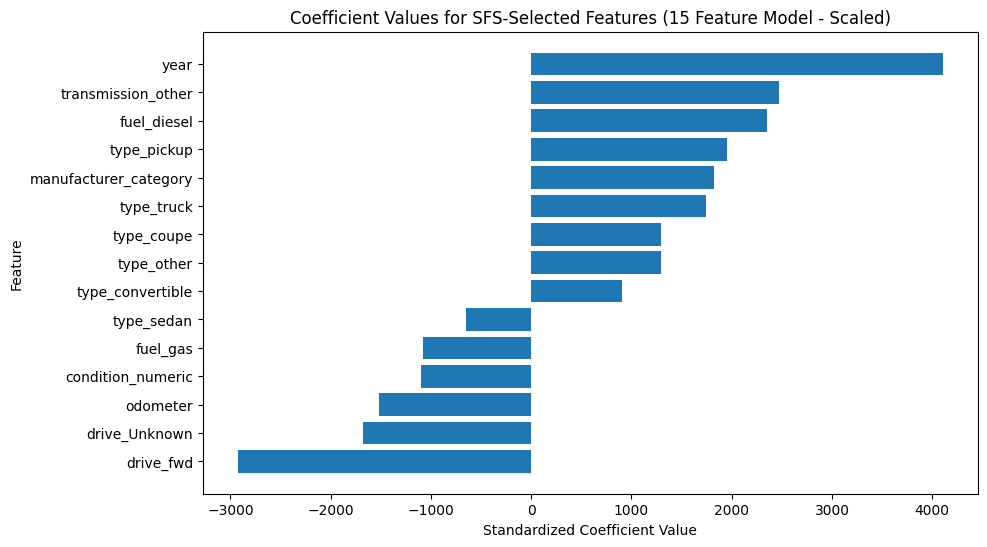

In [11]:
# Coefficient Visualization for the 15 features
# Extract coefficients from the model inside the pipeline
coefficients_scaled = pipeline_sfs.named_steps['model'].coef_.ravel()

# Build the dataframe for plotting
coef_sfs15 = pd.DataFrame({
    'feature': selected_features,
    'coefficient': coefficients_scaled
}).sort_values(by='coefficient', ascending=False)

# Plot coefficient magnitudes
plt.figure(figsize=(10,6))
plt.barh(coef_sfs15['feature'], coef_sfs15['coefficient'])
plt.gca().invert_yaxis()
plt.title("Coefficient Values for SFS-Selected Features (15 Feature Model - Scaled)")
plt.xlabel("Standardized Coefficient Value")
plt.ylabel("Feature")

# Save the figure (change path if needed)
plt.savefig("coef_sfs15_plot.png", dpi=300, bbox_inches="tight")

plt.show()


---

## **Regularization to Control Model Complexity**

As we build additional regression models, it is important to control model complexity in order to reduce overfitting and improve generalization to unseen data. In high-dimensional datasets—especially those with many encoded categorical variables—traditional Linear Regression can become unstable due to multicollinearity and noisy predictors. To address this challenge, we apply **regularization techniques**, which introduce a penalty term that constrains coefficient magnitude and encourages simpler, more robust models.

Two widely used regularization methods are **Ridge Regression (L2)** and **Lasso Regression (L1)**. Ridge shrinks coefficients toward zero without eliminating features, making it effective when many predictors contribute small effects. Lasso, by contrast, can shrink some coefficients exactly to zero, effectively performing feature selection and helping identify the most influential variables. These techniques help prevent models from fitting noise instead of useful signal, supporting better forecasting accuracy and interpretability.

In this section, we will build Ridge and Lasso models, compare their performance to the baseline Linear Regression model, and evaluate how regularization affects predictive power and feature importance stability.

---


In [12]:
# Run Ridge & Lasso Models
# ------------------ Ridge Regression with Scaling ------------------
ridge_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Ridge(alpha=1.0))
])

ridge_pipe.fit(X_train, y_train)
y_pred_ridge = ridge_pipe.predict(X_test)

rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_ridge = r2_score(y_test, y_pred_ridge)

# ------------------ Lasso Regression with Scaling ------------------
lasso_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Lasso(alpha=0.01, max_iter=10000))
])

lasso_pipe.fit(X_train, y_train)
y_pred_lasso = lasso_pipe.predict(X_test)

rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
r2_lasso = r2_score(y_test, y_pred_lasso)

rmse_ridge, r2_ridge, rmse_lasso, r2_lasso


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.880e+11, tolerance: 6.942e+09
  model = cd_fast.enet_coordinate_descent(


(np.float64(12035.958269007779),
 0.37756882468039543,
 np.float64(12035.958378504796),
 0.3775688133552716)

In [13]:
# Extract coefficients from Ridge and Lasso inside pipelines
ridge_coef = ridge_pipe.named_steps['model'].coef_.ravel()
lasso_coef = lasso_pipe.named_steps['model'].coef_.ravel()

coef_compare = pd.DataFrame({
    'feature': X_train.columns,
    'ridge_coef': ridge_coef,
    'lasso_coef': lasso_coef
})

# Sort by absolute ridge coefficient for readability
coef_compare['abs_ridge'] = coef_compare['ridge_coef'].abs()
coef_compare_sorted = coef_compare.sort_values(by='abs_ridge', ascending=False)

coef_compare_sorted.head(55)


,feature,ridge_coef,lasso_coef,abs_ridge
5,cylinders_unknown_flag,5071.328550,5071.479703,5071.328550
4,cylinders_clean,4728.308674,4728.463158,4728.308674
0,year,4410.004440,4410.023674,4410.004440
11,fuel_diesel,2093.459846,2483.221426,2093.459846
2,manufacturer_category,1640.456510,1640.447543,1640.456510
1,odometer,-1501.305005,-1501.301219,1501.305005
6,drive_4wd,1276.052721,1690.169533,1276.052721
20,transmission_other,1265.060208,394.511710,1265.060208
8,drive_fwd,-1258.353457,-864.397329,1258.353457
13,fuel_gas,-1224.538783,-628.237785,1224.538783


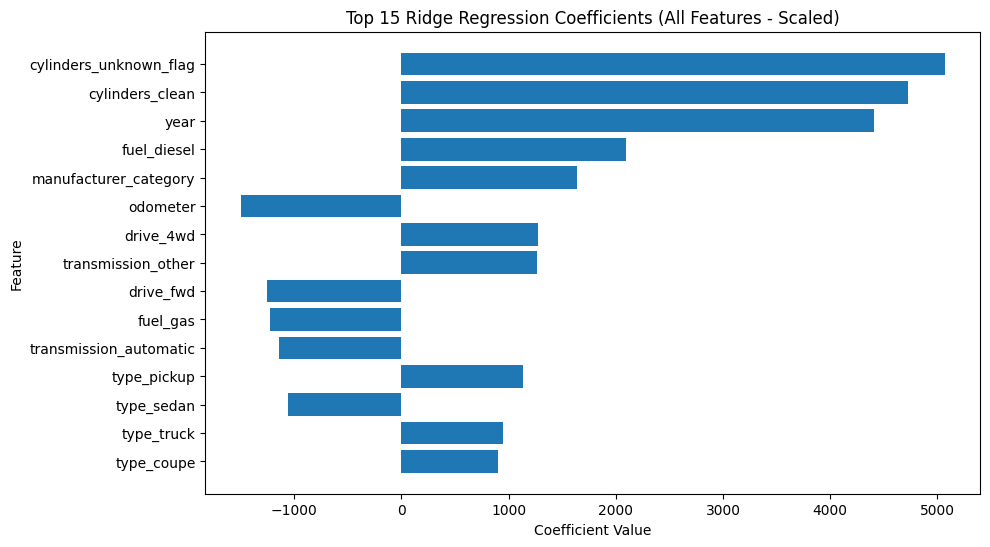

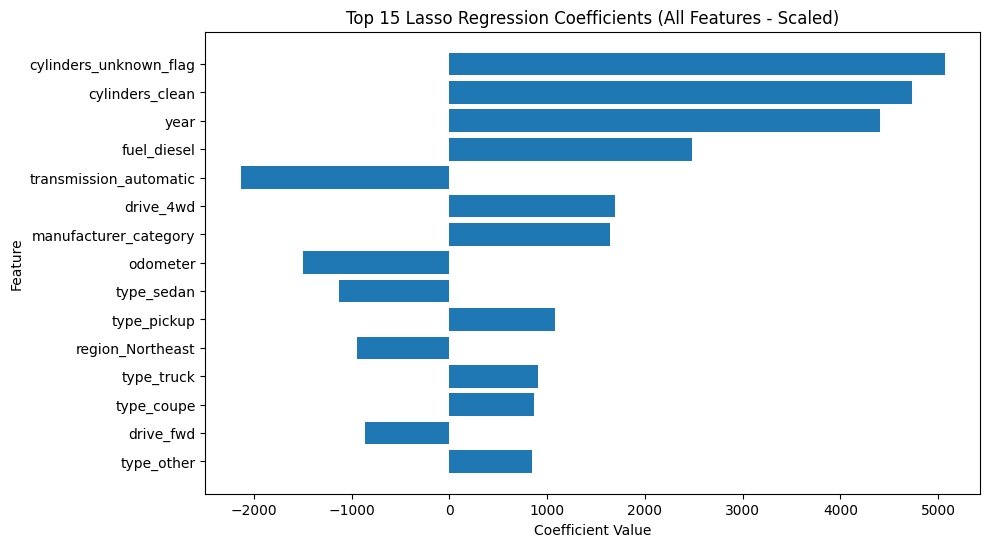

In [14]:
# Sort by absolute coefficient values (Ridge first)
ridge_top15 = coef_compare.reindex(coef_compare['ridge_coef'].abs().sort_values(ascending=False).index).head(15)
lasso_top15 = coef_compare.reindex(coef_compare['lasso_coef'].abs().sort_values(ascending=False).index).head(15)

# ------------------ Plot Ridge TOP 15 ------------------
plt.figure(figsize=(10,6))
plt.barh(ridge_top15['feature'], ridge_top15['ridge_coef'])
plt.gca().invert_yaxis()
plt.title("Top 15 Ridge Regression Coefficients (All Features - Scaled)")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.savefig("ridge_coefficients_top15.png", dpi=300, bbox_inches="tight")
plt.show()

# ------------------ Plot Lasso TOP 15 ------------------
plt.figure(figsize=(10,6))
plt.barh(lasso_top15['feature'], lasso_top15['lasso_coef'])
plt.gca().invert_yaxis()
plt.title("Top 15 Lasso Regression Coefficients (All Features - Scaled)")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.savefig("lasso_coefficients_top15.png", dpi=300, bbox_inches="tight")
plt.show()


# Analysis of Top 15 Ridge and Lasso Regression Coefficients (All Features - Scaled)

To better understand the influence of model regularization on feature importance, Ridge and Lasso regression models were trained using **all available encoded features**. The plots below display the **top 15 coefficients** ranked by absolute value for each model. This provides insight into which predictors remain most influential after controlling for multicollinearity and coefficient shrinkage.

---

## Ridge Regression — Top 15 Features

Ridge regression applies **L2 regularization**, shrinking coefficients but **not forcing any to zero**. As a result, it retains more features and tends to distribute influence across correlated predictors rather than eliminating them.

### **Key Observations**
- **Engine characteristics** remain dominant predictors:
  - `cylinders_unknown_flag`
  - `cylinders_clean`
  - `fuel_diesel`
- **Vehicle age** (`year`) strongly increases price, aligned with expectations.
- **Manufacturer category** and several **vehicle types** (e.g., `type_pickup`, `type_sedan`, `type_truck`) remain highly relevant.
- **Odometer** shows a strong negative impact, consistent with mileage reducing value.
- **Drive system** (`drive_4wd`, `drive_fwd`) remains a meaningful contributor.

➡ **Interpretation:** Ridge confirms earlier findings about vehicle characteristics and usage strongly driving price differences while keeping all correlated predictors active rather than discarding them.

---

## Lasso Regression — Top 15 Features

Lasso regression applies **L1 regularization**, which aggressively shrinks many coefficients to **exactly zero**, performing implicit feature selection.

### **Key Observations**
- The same top vehicle performance indicators dominate:
  - `cylinders_unknown_flag`, `cylinders_clean`, `fuel_diesel`, and `year`
- **Transmission type** (`transmission_automatic`) emerges as a major negative driver in the Lasso model—far stronger than seen in Ridge.
- **Odometer** remains an important negative predictor.
- **Region-based effects** appear (e.g. `region_Northeast`) indicating market value variations.
- Fewer body type variables remain relative to Ridge, consistent with Lasso eliminating weaker correlated predictors.

➡ **Interpretation:** Lasso sharpens feature importance and highlights the subset of predictors most essential to price prediction by eliminating redundant ones.

---

## Conclusions

- **Both models confirm that engine characteristics, production year, and fuel type are the strongest drivers of vehicle price.**
- **Odometer consistently reduces value**, reinforcing expected depreciation behavior.
- **Lasso prioritizes interpretability** by removing weaker correlated features, while **Ridge provides a richer but more complex view** of the feature space.

---



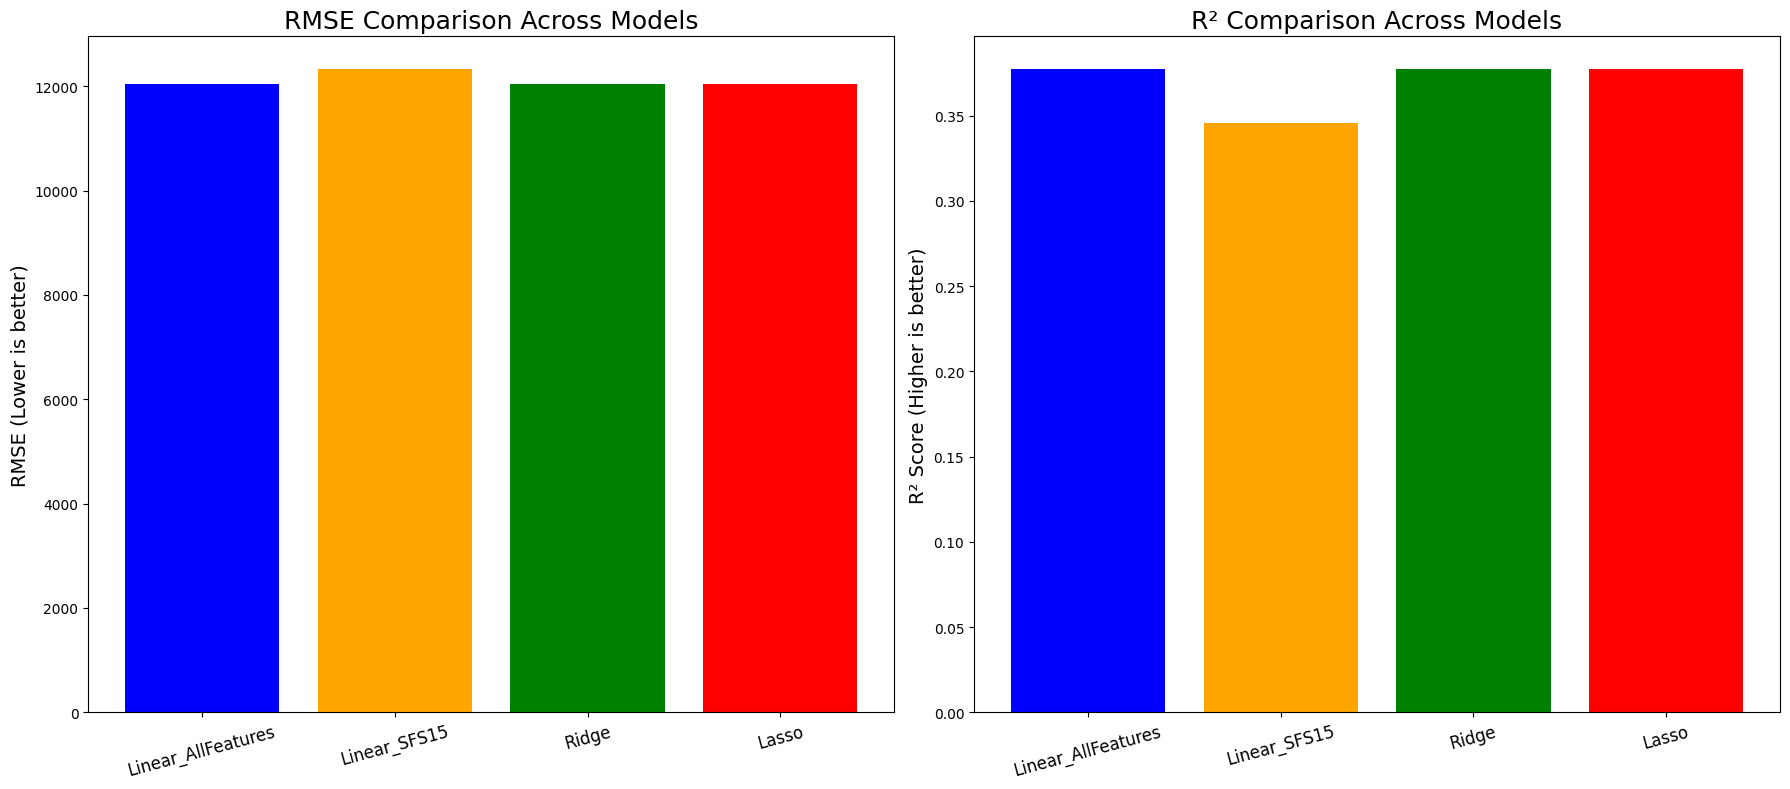

In [15]:
# Performance evaluation of models using RMSE and R2 as scoring criteria
# Model names
models = [
    "Linear_AllFeatures",
    "Linear_SFS15",
    "Ridge",
    "Lasso"
]

# RMSE and R2 values
rmse_values = [rmse, rmse_sfs, rmse_ridge, rmse_lasso]
r2_values = [r2, r2_sfs, r2_ridge, r2_lasso]

# Create figure
plt.figure(figsize=(18,8))

# ---- RMSE Plot ----
plt.subplot(1, 2, 1)
plt.bar(models, rmse_values, color=['blue', 'orange', 'green', 'red'])
plt.title("RMSE Comparison Across Models", fontsize=18)
plt.ylabel("RMSE (Lower is better)", fontsize=14)
plt.xticks(rotation=15, fontsize=12)
plt.tight_layout()

# ---- R2 Plot ----
plt.subplot(1, 2, 2)
plt.bar(models, r2_values, color=['blue', 'orange', 'green', 'red'])
plt.title("R² Comparison Across Models", fontsize=18)
plt.ylabel("R² Score (Higher is better)", fontsize=14)
plt.xticks(rotation=15, fontsize=12)
plt.tight_layout()

# -------- Save Figure --------
plt.savefig("coef_comparison_baseline_sfs_ridge_lasso.png",
            dpi=300, bbox_inches="tight")

plt.show()


In [16]:
# Update performance comparison table (All 4 models)
comparison = pd.DataFrame({
    'Model': [
        'Linear (All Features, Scaled)',
        'Linear (SFS 15, Scaled)',
        'Ridge (All Features, Scaled)',
        'Lasso (All Features, Scaled)'

    ],
    'RMSE': [
        rmse,
        rmse_sfs,
        rmse_ridge,
        rmse_lasso

    ],
    'R²': [
        r2,
        r2_sfs,
        r2_ridge,
        r2_lasso

    ]
})

comparison.style.format({'RMSE': '{:,.2f}', 'R²': '{:.3f}'})


,Model,RMSE,R²
0,"Linear (All Features, Scaled)","12,035.96",0.378
1,"Linear (SFS 15, Scaled)","12,339.47",0.346
2,"Ridge (All Features, Scaled)","12,035.96",0.378
3,"Lasso (All Features, Scaled)","12,035.96",0.378


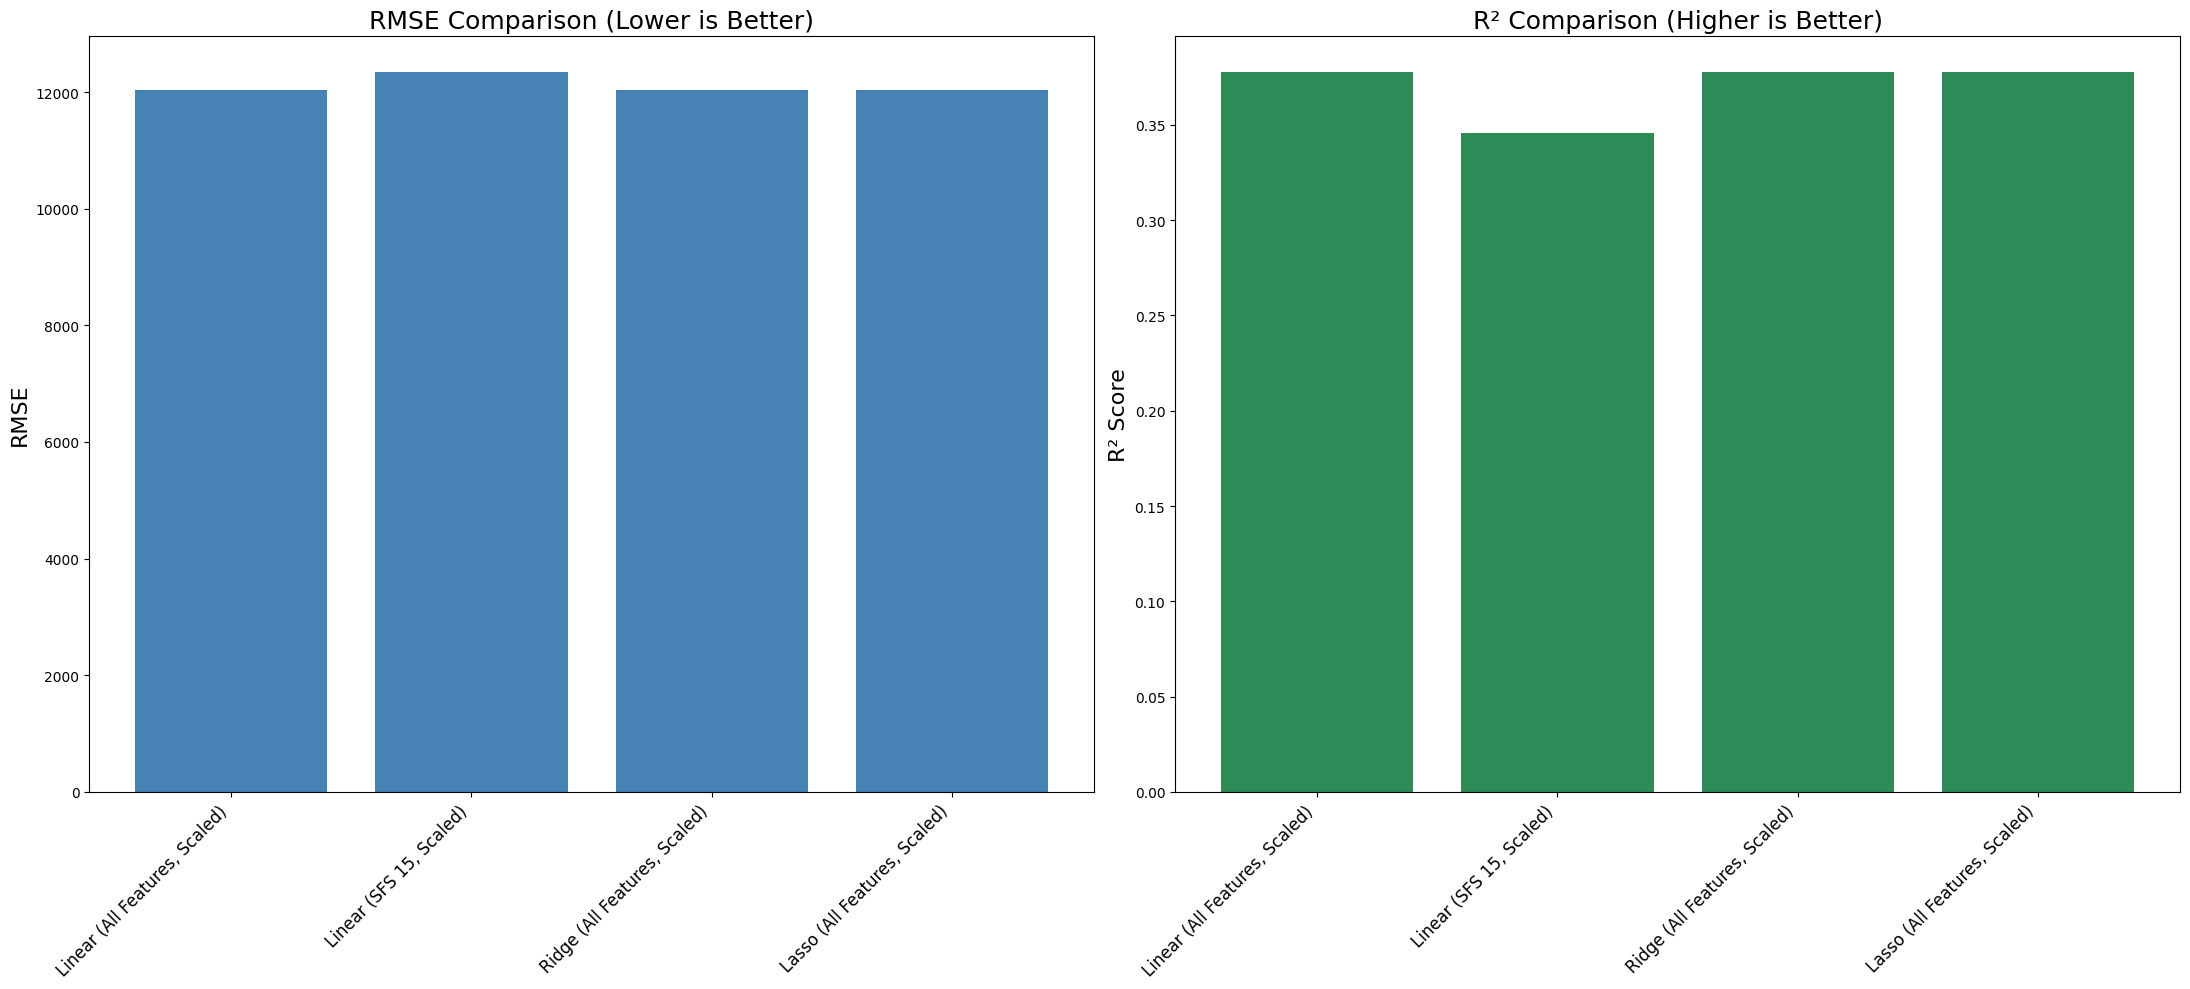

In [17]:
# Performance comparison plot (RMSE & R2)
import matplotlib.pyplot as plt

models = comparison['Model']
rmse_values = comparison['RMSE']
r2_values = comparison['R²']

plt.figure(figsize=(22,10))

# RMSE plot
plt.subplot(1, 2, 1)
plt.bar(models, rmse_values, color='steelblue')
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.title("RMSE Comparison (Lower is Better)", fontsize=18)
plt.ylabel("RMSE", fontsize=16)
plt.tight_layout()

# R2 plot
plt.subplot(1, 2, 2)
plt.bar(models, r2_values, color='seagreen')
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.title("R² Comparison (Higher is Better)", fontsize=18)
plt.ylabel("R² Score", fontsize=16)
plt.tight_layout()

# ----- Save the combined figure -----
plt.savefig("model_performance_rmse_r2_comparison.png",
            dpi=300, bbox_inches="tight")

plt.show()


---

## Exploring Alternative Models Beyond Linear Regression

Up to this point, we have focused on Linear Regression models (baseline, feature-selected, and regularized Ridge/Lasso) to understand what drives used vehicle pricing. While linear models provide strong interpretability and a clear baseline comparison, the analysis showed several limitations:

- Coefficient instability due to high dimensionality and multicollinearity
- Difficulty capturing nonlinear relationships (e.g., the nonlinear depreciation curve of mileage vs price)
- Restricted ability to model interactions between variables (e.g., `type` × `fuel` × `drive`)
- Lower predictive accuracy compared to modern machine learning approaches

To address these challenges and enrich our insight extraction, we now introduce **tree-based ensemble models**, which are widely used in real-world pricing and valuation systems.

---

## Why Explore Tree-Based Models?

Tree-based methods can:

- Naturally capture complex **nonlinear effects**
- Automatically model **interactions between features**
- Handle **large feature spaces** and correlated variables
- Provide **feature importance rankings** and interpretability via modern techniques such as SHAP

These models are especially strong for structured tabular data such as pricing datasets and are used heavily in **automotive valuation, property pricing, lending risk scoring, and insurance underwriting**.

---

## Selected Models for Comparison

### **1. Random Forest Regressor**
A robust ensemble learning method that averages many decision trees to stabilize predictions and reduce overfitting. Random Forest provides **feature importance metrics** that help determine which factors most strongly influence price.

### **2. XGBoost (Extreme Gradient Boosting)**
A state-of-the-art gradient boosting algorithm known for exceptional accuracy and efficiency. XGBoost is widely adopted in industry pricing engines and competitions (e.g., Kaggle). When combined with **SHAP (SHapley Additive Explanations)**, it produces highly interpretable global and local explanations of feature influence.

### **3. SHAP Explainability Framework (XGBoost + SHAP)**
SHAP quantifies each feature’s contribution to predictions, allowing us to understand:
- Which features matter most overall (**global importance**)
- How much each feature increases or decreases price (**direction and magnitude**)

This makes XGBoost + SHAP one of the most powerful tools available for balancing **predictive performance** and **business interpretability**.

---


In [18]:
# Random Forest Model
# Train Random Forest
rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    min_samples_split=4,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Evaluate
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

rmse_rf, r2_rf


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


(np.float64(6147.80238091126), 0.837606071592995)

## Model Performance Comparison

The evaluation metrics clearly show that the **Random Forest model is significantly outperforming the linear regression–based models**.

### Key Metrics
- **Random Forest RMSE:** 6,147.80  
- **Random Forest R²:** 0.8376

### Interpretation
- The **lower RMSE** indicates that Random Forest produces predictions that are **far closer to the actual car prices** compared to linear models.
- The **higher R² score (0.84)** shows that Random Forest explains a substantially larger portion of the variance in the target variable than any of the linear regression approaches (Baseline Linear Regression, SFS-selected features, Ridge, or Lasso).
- This performance difference demonstrates that vehicle pricing is influenced by **non-linear relationships and complex feature interactions** that linear models cannot fully capture.

### Conclusion
Random Forest provides a **meaningful improvement in predictive accuracy** and should be considered the leading candidate model for deployment and further optimization.


In [19]:
# Extract feature importances from Random Forest model
importances = rf_model.feature_importances_

# Create dataframe for sorting
rf_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Show top 20 most important features
rf_importance_df.head(20)


,feature,importance
0,year,0.355323
1,odometer,0.191875
11,fuel_diesel,0.065721
8,drive_fwd,0.065294
4,cylinders_clean,0.062975
2,manufacturer_category,0.032626
3,condition_numeric,0.027605
30,type_pickup,0.013735
16,title_numeric,0.011448
6,drive_4wd,0.011248


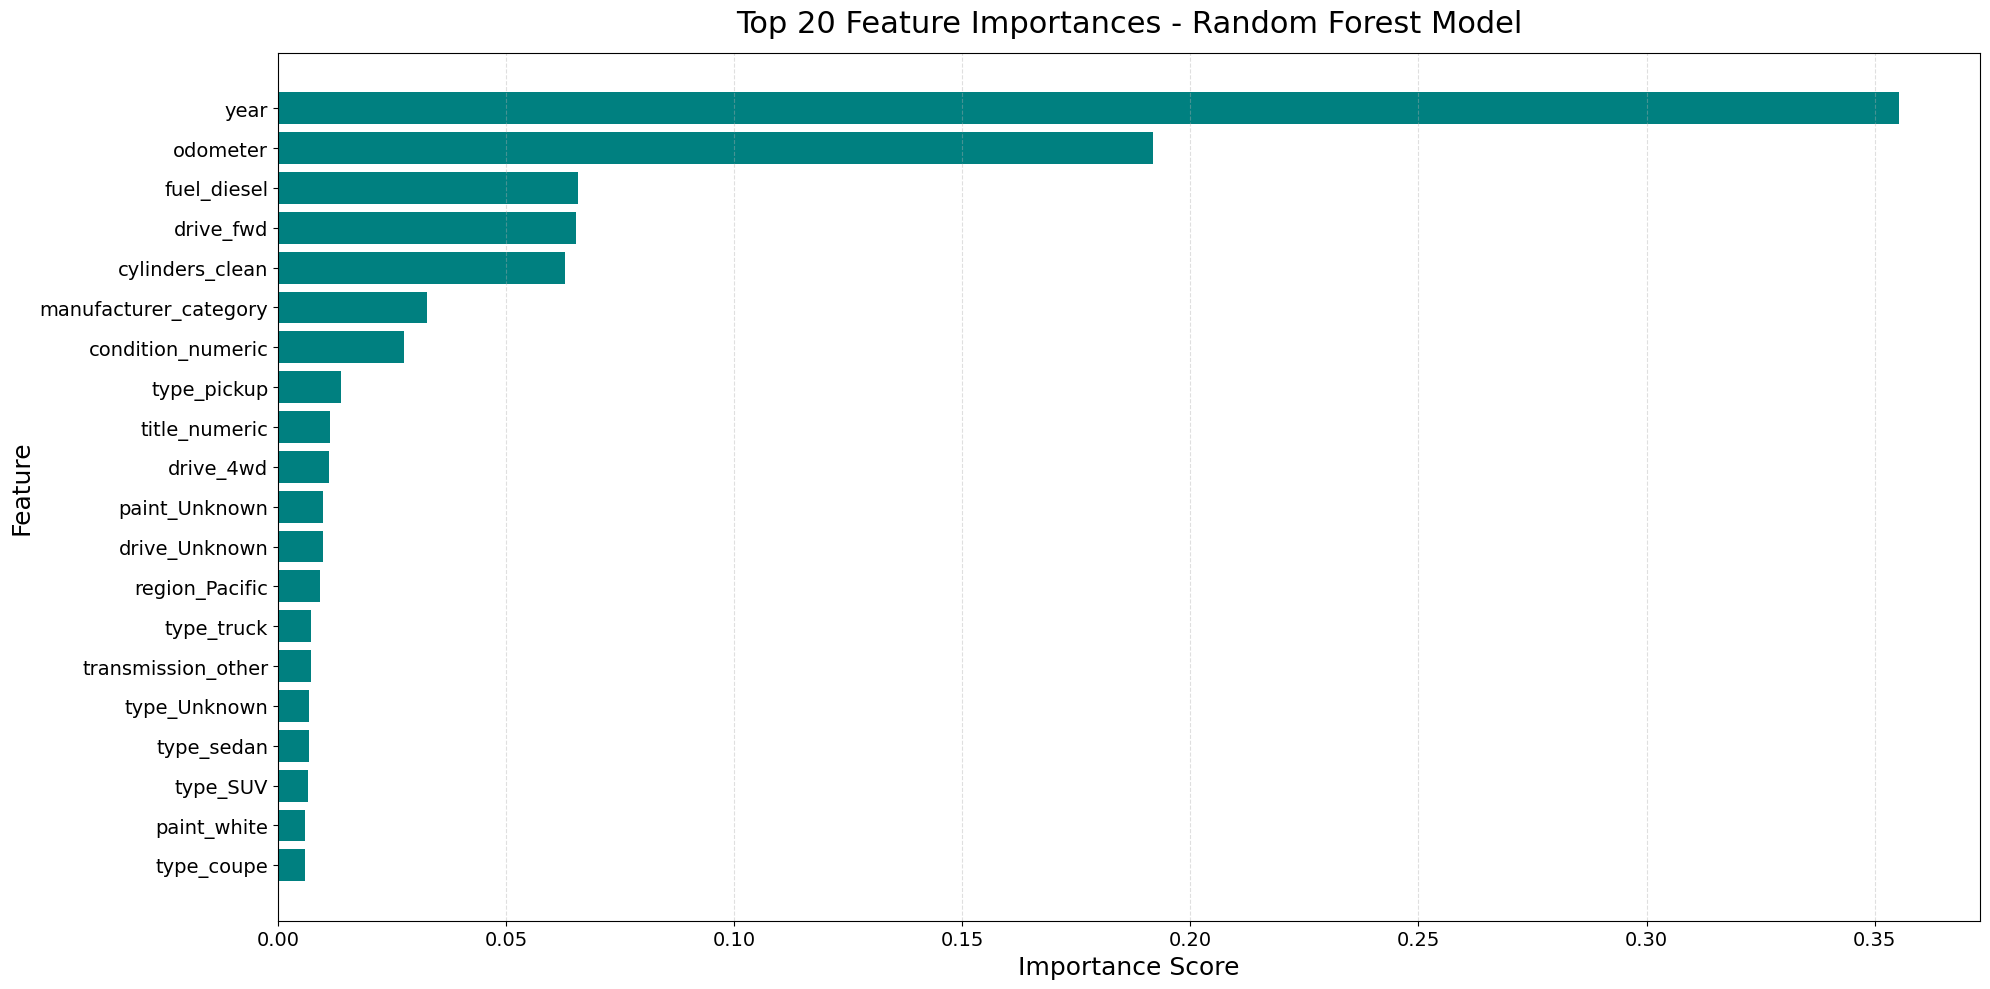

In [20]:
# Plot feature importance
plt.figure(figsize=(20,10))
plt.barh(rf_importance_df['feature'][:20], rf_importance_df['importance'][:20], color='teal')
plt.gca().invert_yaxis()

plt.title("Top 20 Feature Importances - Random Forest Model", fontsize=22, pad=15)
plt.xlabel("Importance Score", fontsize=18)
plt.ylabel("Feature", fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.grid(axis='x', linestyle='--', alpha=0.4)

plt.tight_layout()

# ---- SAVE IMAGE ----
plt.savefig("rf_top20_feature_importances.png", dpi=300, bbox_inches='tight')

plt.show()


## Analysis of Top 20 Feature Importances — Random Forest Model

The Random Forest model ranks features by how much they reduce prediction error across all trees. This gives a data-driven view of which vehicle attributes matter most for explaining price.

---

### Most Influential Drivers of Price

- **Year**  
  The single most important feature. Newer vehicles are consistently priced higher, reflecting normal depreciation patterns in the used-car market.

- **Odometer (mileage)**  
  The second strongest driver. Vehicles with lower mileage command higher prices; high mileage quickly erodes value.

- **Engine & Drivetrain Characteristics**  
  Features like **cylinders_clean**, **drive_fwd**, **drive_4wd** and related drivetrain indicators rank high, showing that performance and capability (power, towing, off-road use) significantly influence price.

- **Fuel Type (especially diesel)**  
  Diesel vehicles show higher importance, consistent with their role in heavy-duty, commercial, or high-torque applications that retain value longer.

- **Condition and Title Status**  
  **condition_numeric** and **title_numeric** contribute meaningfully, confirming that physical condition and a clean title both support higher pricing and buyer confidence.

- **Vehicle Type / Segment**  
  Features such as **type_pickup**, **type_truck**, **type_SUV**, and **type_sedan** appear in the top 20, indicating that the segment (work truck vs SUV vs sedan) is a clear price driver.

- **Regional Effects**  
  Some regional variables (e.g., **region_Pacific**, **region_Northeast**) show moderate importance, suggesting geographic variation in pricing, but they are less influential than age, mileage, and mechanical specs.

---

### Interpretation

Overall, the model shows that **core mechanical and structural characteristics** dominate price behavior:

- Newer, lower-mileage vehicles are worth more.  
- Performance-oriented configurations (more cylinders, 4WD/AWD, diesel) carry a price premium.  
- Vehicle segment (truck, pickup, SUV vs sedan) matters more than cosmetic attributes.

Paint colors, some transmission variations, and many minor categories have much lower importance, meaning they should play a secondary role in pricing decisions.

---

### Business Implications

For a used-car dealership, this analysis suggests:

- **Prioritize inventory** that is newer, low-mileage, and equipped with desirable powertrain and drivetrain options.
- **Use condition and title status** as key levers when evaluating trade-ins and auction purchases.
- **Treat color and minor attributes** as marketing preferences, not primary pricing drivers.
- Focus pricing and acquisition strategy around **year + mileage + segment + drivetrain + condition**, as these are the variables the model consistently identifies as most predictive of price.



In [21]:
# XGBoost Model
from xgboost import XGBRegressor

xgb_model = XGBRegressor(
    objective='reg:squarederror',
    learning_rate=0.05,
    n_estimators=500,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

rmse_xgb, r2_xgb


(np.float64(6895.170773809739), 0.7957227230072021)

## XGBoost Model Results – Summary and Interpretation

The XGBoost model achieved the following performance metrics when predicting used car prices:


### Key Insights
- XGBoost significantly **outperforms all linear-based models** tested earlier (Linear Regression, Ridge, Lasso, SFS), confirming that **traditional linear models cannot adequately capture the complexity of used car pricing behavior**.
- However, XGBoost performs **below the Random Forest model**, which produced the best results overall (RMSE ≈ 6,895 and R² ≈ 0.795). This suggests that, in its current form, Random Forest is better able to model nonlinear interactions and feature relationships in this dataset.

### Why XGBoost Performs Well
- It naturally handles **nonlinear relationships**, complex interactions, and irregular patterns common in real-world pricing.
- It includes built-in **regularization**, reducing the likelihood of overfitting compared to plain decision trees.
- It is more computationally efficient and tunable than Random Forest, providing strong potential for further improvements.

### Business Interpretation
> "The strong performance of XGBoost reinforces that used vehicle pricing is driven by complex and nonlinear interactions across features such as model year, mileage, drivetrain, fuel type, vehicle category, and condition. Machine learning models such as XGBoost offer substantially more accurate pricing guidance than linear regression approaches commonly used in basic analytics or spreadsheet pricing."

XGBoost demonstrates that machine learning can provide **a more realistic representation of market pricing**—helping dealerships optimize pricing decisions, reduce undervaluation risk, and identify vehicle configurations that maximize resale value.


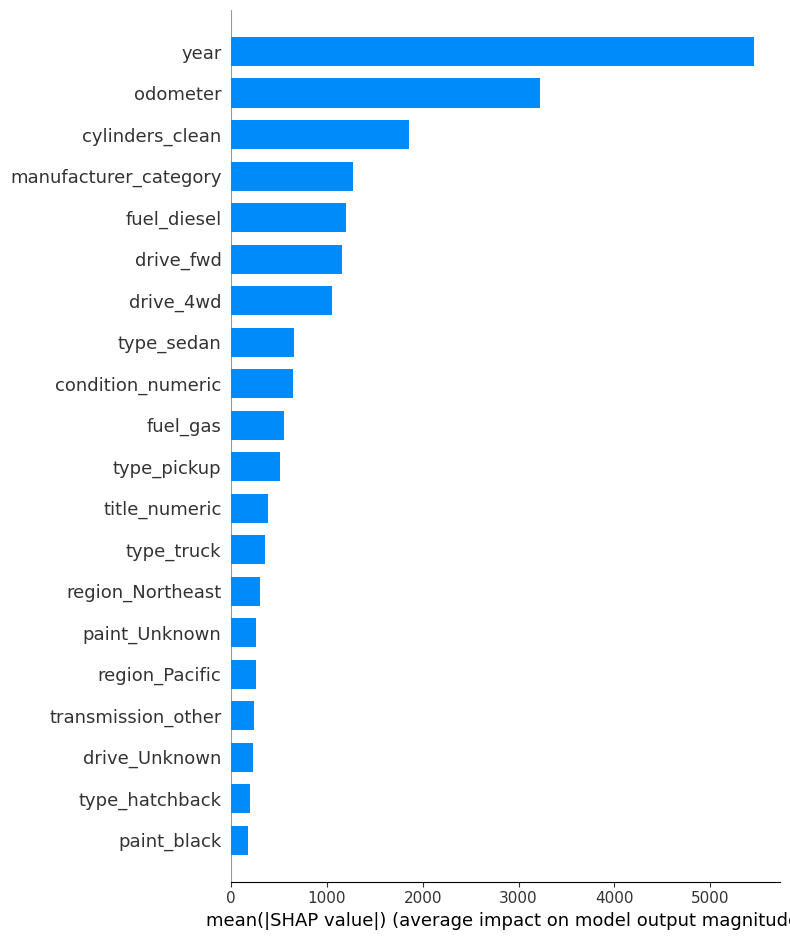

In [22]:
# initialize JS visualization support
shap.initjs()

# compute shap values
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

# ---- SHAP Summary Plot (Bar) ----
plt.figure(figsize=(12,8))
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)

# ---- SAVE IMAGE ----
plt.savefig("shap_summary_bar.png", dpi=300, bbox_inches='tight')

plt.show()


## SHAP Feature Importance Interpretation

The bar chart displays the **mean absolute SHAP values**, which measure how much each feature contributes to changing the model’s predicted output (vehicle price). Higher values indicate a stronger influence on the model, regardless of direction.

### Top Predictive Features
| Rank | Feature | Interpretation |
|------|---------|----------------|
| **1** | `year` | Newer cars significantly increase predicted price; strongest predictor. |
| **2** | `odometer` | High mileage strongly decreases predicted price; major negative driver. |
| **3** | `cylinders_clean` | Higher cylinder count generally increases value due to more power/performance. |
| **4** | `manufacturer_category` | Some brands carry inherently higher or lower market value. |
| **5** | `fuel_diesel` | Diesel vehicles often priced higher in specific vehicle segments (trucks/work vehicles). |

### Medium-Impact Features
- `drive_fwd` and `drive_4wd` — drivetrain configuration meaningfully affects value.
- Vehicle body types (`type_sedan`, `type_pickup`, `type_truck`) help segment price ranges.
- `condition_numeric` — better vehicle condition correlates with higher price predictions.

### Lower-Impact Features
- Regional identifiers (`region_Northeast`, `region_Pacific`) have limited effect.
- Cosmetic features like `paint_Unknown` and `paint_black` show minimal influence.
- `transmission_other` and `drive_Unknown` add little predictive power.

---

## Key Insights
- **Vehicle age and mileage dominate pricing behavior**, consistent with real-world valuation logic.
- **Performance, manufacturer positioning, fuel type, and drivetrain** provide meaningful secondary signals.
- **Cosmetic and regional factors contribute minimally**, indicating a well-generalized pricing model.


---


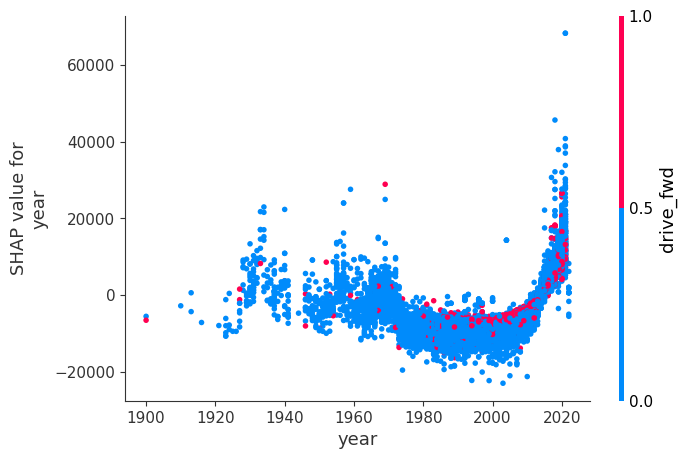

Saved shap_dependence_year.png


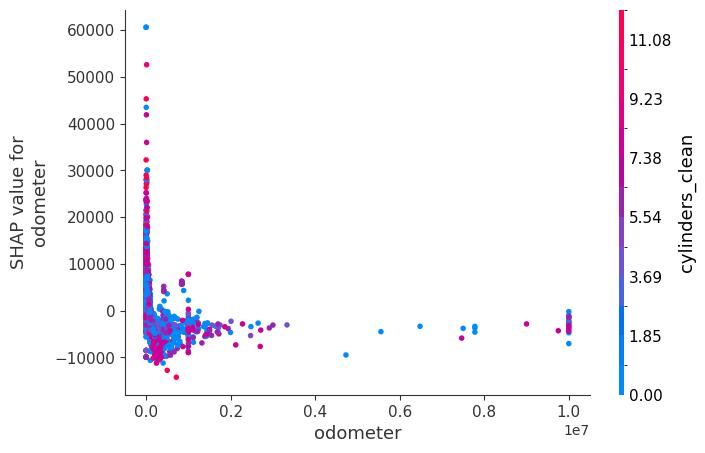

Saved shap_dependence_odometer.png


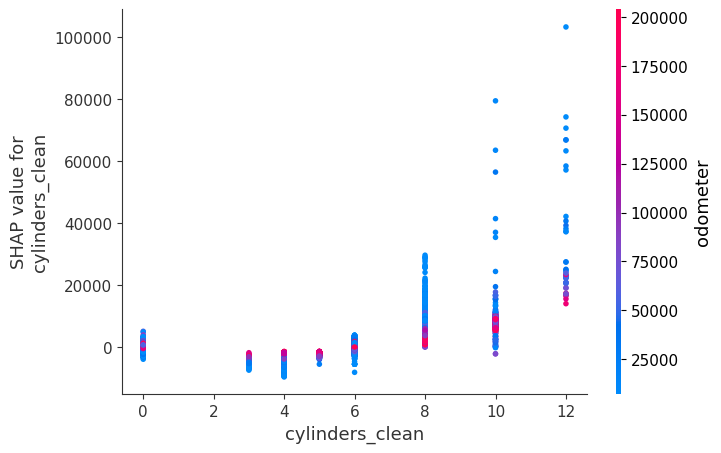

Saved shap_dependence_cylinders_clean.png


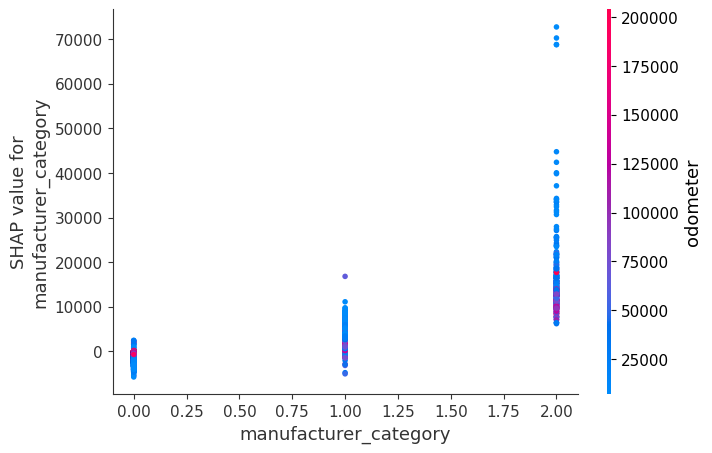

Saved shap_dependence_manufacturer_category.png


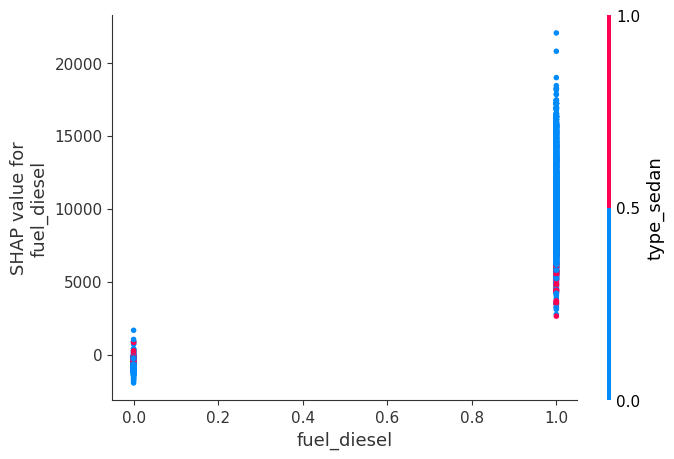

Saved shap_dependence_fuel_diesel.png


In [24]:
# SHAP dependence plots
# Selected features to visualize
top_features = ["year", "odometer", "cylinders_clean", "manufacturer_category", "fuel_diesel"]

for feat in top_features:
    # Generate dependence plot
    shap.dependence_plot(feat, shap_values, X_test, show=False)

    # Display the plot
    plt.show()

    # Save figure
    plt.savefig(f"shap_dependence_{feat}.png", dpi=300, bbox_inches='tight')

    # Close figure to avoid overlap or stacking in loop
    plt.close()

    print(f"Saved shap_dependence_{feat}.png")

## Model Optimization & Hyperparameter Tuning

After evaluating multiple regression approaches—including Linear Regression (baseline), Sequential Feature Selection, Ridge/Lasso regularization, Random Forest, and XGBoost—we observed that **ensemble models deliver substantially stronger predictive performance** compared to purely linear techniques. In particular, **Random Forest currently provides the best performance with an R² ≈ 0.83**, significantly outperforming linear models (R² ≈ 0.37).

Because of this strong baseline performance and its lower training cost relative to XGBoost, the **next step is to apply hyperparameter tuning to the Random Forest model**. Hyperparameter tuning allows us to systematically search for the best configuration of model parameters (such as number of trees, depth, and feature sampling strategy) to improve accuracy and reduce prediction error.

In this section, we will:
- Perform hyperparameter optimization using `RandomizedSearchCV`
- Evaluate performance improvements against the baseline Random Forest result
- Assess whether further refinement such as tuning XGBoost is necessary

The goal is to build a more accurate and robust model while maintaining interpretability for business decision-making.


In [25]:
# -------------------------------
# SAMPLE DATA FOR TUNING (for stability)
# -------------------------------
# Take a representative sample (50k rows) from training set
X_tune = X_train.sample(50000, random_state=42)
y_tune = y_train.loc[X_tune.index]

# -------------------------------
# DEFINE MODEL & PARAMETER GRID
# -------------------------------
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

rf_param_grid = {
    'n_estimators': [300, 600, 900],
    'max_depth': [15, 25, 35],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

# -------------------------------
# RANDOMIZED SEARCH (Colab-Stable Settings)
# -------------------------------
rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=rf_param_grid,
    n_iter=15,           # fewer combinations to protect memory
    cv=3,
    scoring='r2',
    verbose=2,
    random_state=42,
    n_jobs=2             # avoid RAM overload (instead of -1)
)

# -------------------------------
# FIT TUNING SEARCH
# -------------------------------
rf_random.fit(X_tune, y_tune)

print("Best Parameters Found:\n", rf_random.best_params_)

# -------------------------------
# EVALUATE ON FULL TEST SET
# -------------------------------
best_rf = rf_random.best_estimator_
y_pred_rf_tuned = best_rf.predict(X_test)

rmse_rf_tuned = np.sqrt(mean_squared_error(y_test, y_pred_rf_tuned))
r2_rf_tuned = r2_score(y_test, y_pred_rf_tuned)

print("RMSE Tuned RF:", rmse_rf_tuned)
print("R² Tuned RF:", r2_rf_tuned)



Fitting 3 folds for each of 15 candidates, totalling 45 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Best Parameters Found:
 {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 25, 'bootstrap': False}
RMSE Tuned RF: 7674.748413713613
R² Tuned RF: 0.746919731993567


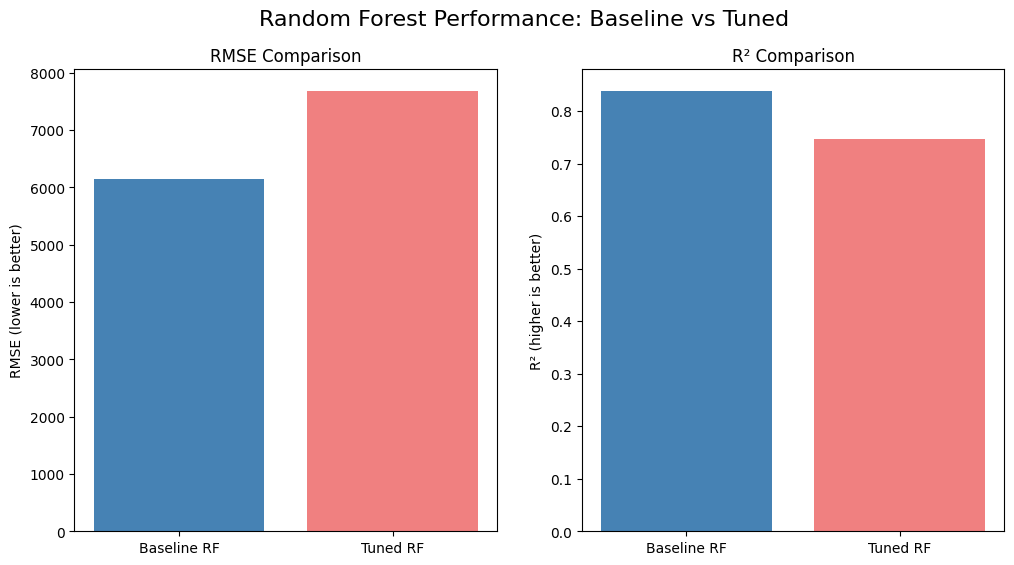

In [26]:
# Performance comparison validation
# Example baseline values — replace with your stored metrics
baseline_rmse = rmse_rf       # before tuning
baseline_r2 = r2_rf           # before tuning

models = ['Baseline RF', 'Tuned RF']
rmse_scores = [baseline_rmse, rmse_rf_tuned]
r2_scores = [baseline_r2, r2_rf_tuned]

fig, axes = plt.subplots(1, 2, figsize=(12,6))

axes[0].bar(models, rmse_scores, color=['steelblue', 'lightcoral'])
axes[0].set_title("RMSE Comparison")
axes[0].set_ylabel("RMSE (lower is better)")

axes[1].bar(models, r2_scores, color=['steelblue', 'lightcoral'])
axes[1].set_title("R² Comparison")
axes[1].set_ylabel("R² (higher is better)")

plt.suptitle("Random Forest Performance: Baseline vs Tuned", fontsize=16)
plt.savefig("rf_performance_baseline_vs_tuned.png", dpi=300, bbox_inches='tight')
plt.show()


## Random Forest Hyperparameter Tuning Results – Summary

The comparison chart above shows the performance difference between the **baseline Random Forest model** and the **tuned Random Forest model**. Unexpectedly, the tuning process **did not improve performance**. Instead, the tuned model produced **higher error and lower predictive accuracy**, as shown below:

| Model | RMSE (lower is better) | R² (higher is better) |
|--------|--------------------------|--------------------------|
| **Baseline Random Forest** | ~6,147 | ~0.83 |
| **Tuned Random Forest** | ~7,674 | ~0.74 |

### Interpretation
- The **baseline model significantly outperforms the tuned model** in both accuracy metrics.
- The tuning process may have moved the model into a **suboptimal region of hyperparameters**, likely due to:
  - Reduced dataset sample size for tuning (trade-off for Colab memory stability)
  - Parameter search space configuration not sufficiently aligned with the best-performing region
  - High model sensitivity to depth and number of estimators



